<a href="https://colab.research.google.com/github/VladimirBoshnjakovski/explainable-ai-thesis-code/blob/main/05_blackbox_pfi_and_surogate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ──────────────── FILE UPLOAD ────────────────
from google.colab import files  # Enables file upload in Google Colab

# ──────────────── CORE LIBRARIES ────────────────
import numpy as np               # Numerical operations
import pandas as pd              # Data manipulation and analysis
import matplotlib.pyplot as plt  # Visualization (basic plots)
import seaborn as sns            # Statistical visualizations

# ──────────────── SKLEARN: PREPROCESSING & SPLITTING ────────────────
from sklearn.model_selection import train_test_split     # Splitting data into train/test sets
from sklearn.preprocessing import StandardScaler         # Standardization of numerical features

# ──────────────── SKLEARN: MODELS ────────────────
from sklearn.linear_model import LogisticRegression      # Logistic Regression model
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text  # Decision Tree model and visualization

# ──────────────── SKLEARN: METRICS ────────────────
from sklearn.metrics import (
    accuracy_score,              # Overall accuracy
    precision_score,             # Precision for positive class
    recall_score,                # Recall for positive class
    f1_score,                    # Harmonic mean of precision and recall
    roc_auc_score,               # Area under ROC curve
    log_loss,                    # Logarithmic loss for probabilistic predictions
    classification_report,       # Full classification summary
    confusion_matrix,            # Confusion matrix
    mean_absolute_error,         # For regression
    mean_squared_error,          # For regression
    r2_score                     # Coefficient of determination (regression)
)

# ──────────────── TENSORFLOW / KERAS ────────────────
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, optimizers  # Deep learning modules

# ──────────────── MISCELLANEOUS ────────────────
from tqdm import tqdm  # Progress bar for loops and batch operations


In [2]:
# ──────────────── FILE UPLOAD IN GOOGLE COLAB ────────────────

uploaded = files.upload()
# Opens a file upload dialog in Google Colab, allowing the user to select a local file.
# The 'uploaded' object is a dictionary with filenames as keys and file content as values.

df = pd.read_csv(next(iter(uploaded)))
# Reads the first uploaded file into a pandas DataFrame.
# 'next(iter(uploaded))' retrieves the filename of the first uploaded file from the dictionary.

Saving heart_hotwired.csv to heart_hotwired.csv


In [3]:
# ──────────────── PREPROCESS ────────────────

# Drop irrelevant column and rename target column for simplicity
df = df.drop(columns=['source']) \
       .rename(columns={'Presence of Heart Disease (1=Yes)': 'target'})

# Separate features (X) and target (y)
X = df.drop(columns=['target']).values  # Convert features to NumPy array
y = df['target'].values                 # Target variable as NumPy array

# Perform stratified train-test split to maintain target class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% of data used for testing
    stratify=y,              # Ensures class balance in train/test sets
    random_state=42         # For reproducibility
)

# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training data and transform
X_test  = scaler.transform(X_test)       # Transform test data using same scaler

# ──────────────── MODEL BUILDER ────────────────

def build_model(input_dim):
    """Builds a regularized neural network for binary classification."""
    l2 = regularizers.l2(1e-4)  # L2 regularization factor

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),                     # Input layer
        layers.Dense(64, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.3),                                  # Dropout for regularization
        layers.Dense(32, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=l2),
        layers.Dense(1, activation='sigmoid')                 # Output layer (binary classification)
    ])

    # Compile with Adam optimizer, binary crossentropy loss, and AUC tracking
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Track both accuracy and AUC
    )
    return model

# Instantiate model with input dimension matching training features
model = build_model(X_train.shape[1])

# ──────────────── CALLBACKS ────────────────

# Stop training early if validation AUC doesn't improve for 10 consecutive epochs
es = callbacks.EarlyStopping(
    monitor='val_auc',      # Monitor validation AUC
    mode='max',             # Higher AUC is better
    patience=10,            # Wait for 10 epochs before stopping
    restore_best_weights=True  # Revert to best weights after early stop
)

# Reduce learning rate if validation loss plateaus
rlr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.5,             # Reduce LR by half
    patience=5,             # Wait 5 epochs before reducing
    min_lr=1e-5,            # Minimum learning rate
    verbose=1               # Print updates
)

# ──────────────── TRAIN ────────────────

history = model.fit(
    X_train, y_train,
    validation_split=0.2,      # 20% of training data used for validation
    epochs=100,                # Maximum number of epochs
    batch_size=16,             # Mini-batch size
    callbacks=[es, rlr],       # Apply early stopping and LR reduction
    verbose=2                  # Print training logs per epoch
)

# ──────────────── EVALUATE ────────────────

# Evaluate model on the test set and print key metrics
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}   |   Test accuracy: {acc:.4f}   |   Test AUC: {auc:.4f}")


Epoch 1/100
52/52 - 3s - 66ms/step - accuracy: 0.6337 - auc: 0.6894 - loss: 0.6467 - val_accuracy: 0.7452 - val_auc: 0.8425 - val_loss: 0.5420 - learning_rate: 1.0000e-03
Epoch 2/100
52/52 - 1s - 10ms/step - accuracy: 0.7578 - auc: 0.8196 - loss: 0.5387 - val_accuracy: 0.7981 - val_auc: 0.8776 - val_loss: 0.4453 - learning_rate: 1.0000e-03
Epoch 3/100
52/52 - 1s - 12ms/step - accuracy: 0.8108 - auc: 0.8725 - loss: 0.4581 - val_accuracy: 0.8606 - val_auc: 0.8987 - val_loss: 0.4019 - learning_rate: 1.0000e-03
Epoch 4/100
52/52 - 1s - 10ms/step - accuracy: 0.8181 - auc: 0.8840 - loss: 0.4429 - val_accuracy: 0.8510 - val_auc: 0.9113 - val_loss: 0.3814 - learning_rate: 1.0000e-03
Epoch 5/100
52/52 - 0s - 5ms/step - accuracy: 0.8253 - auc: 0.8939 - loss: 0.4203 - val_accuracy: 0.8654 - val_auc: 0.9162 - val_loss: 0.3652 - learning_rate: 1.0000e-03
Epoch 6/100
52/52 - 0s - 5ms/step - accuracy: 0.8434 - auc: 0.9052 - loss: 0.4008 - val_accuracy: 0.8798 - val_auc: 0.9243 - val_loss: 0.3511 - le

In [6]:
# ──────────────── EVALUATION PHASE: MODEL VALIDATION ON HOLD-OUT SET ────────────────
# This phase happens *after* model training. We assess how well the trained model generalizes
# to unseen data by evaluating it on a hold-out (test) set that was not used during training or validation.

# 1) Prepare your hold-out set exactly as you did for LIME
label_col = 'target'  # Define the target variable (what we're trying to predict)

# Select all other columns as input features
feature_cols = [c for c in df.columns if c != label_col]

# Split data into training and hold-out sets
# → We use hold-out data here instead of validation split to simulate real-world performance.
df_train, df_holdout = train_test_split(
    df,
    test_size=0.2,      # Use 20% of data for final testing
    random_state=42     # Ensures reproducibility of the split
)

# Convert feature and target columns into NumPy arrays for both sets
X_train = df_train[feature_cols].values
y_train = df_train[label_col].values
X_hold  = df_holdout[feature_cols].values
y_hold  = df_holdout[label_col].values

# Standardize features (fit on training, transform hold-out)
# → Prevents data leakage. Never scale using the test data directly.
scaler = StandardScaler().fit(X_train)
X_hold_scaled = scaler.transform(X_hold)

# 2) Get model predictions on the hold-out set
# → We use these predictions to assess model performance on unseen data
probs_hold = model.predict(X_hold_scaled, verbose=0).flatten()  # Get predicted probabilities
preds_hold = (probs_hold >= 0.5).astype(int)                    # Convert probabilities to binary labels

# 3) Compute metrics
# → These metrics help you understand classification quality across multiple dimensions
print("=== Classification Report ===")
print(classification_report(y_hold, preds_hold, digits=3))  # Includes precision, recall, F1-score

print("=== Other Metrics ===")
print(f"Accuracy : {accuracy_score(y_hold, preds_hold):.3f}")        # Overall correctness
print(f"AUC      : {roc_auc_score(y_hold, probs_hold):.3f}")         # Discrimination power
print(f"Log Loss : {log_loss(y_hold, probs_hold):.3f}")              # Penalizes overconfident wrong predictions

# 4) Show confusion matrix for completeness
# → Helps visualize false positives, false negatives, true positives, and true negatives
cm = confusion_matrix(y_hold, preds_hold)
print("Confusion Matrix:")
print(cm)

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.939     0.885     0.911       122
           1      0.903     0.949     0.926       138

    accuracy                          0.919       260
   macro avg      0.921     0.917     0.919       260
weighted avg      0.920     0.919     0.919       260

=== Other Metrics ===
Accuracy : 0.919
AUC      : 0.959
Log Loss : 0.244
Confusion Matrix:
[[108  14]
 [  7 131]]


In [7]:
# ──────────────── MODEL INTERPRETATION PHASE: PERMUTATION FEATURE IMPORTANCE ────────────────
# This phase comes after training and evaluation.
# It helps explain which features the trained model relies on most for its predictions.
# We do this by measuring how much performance degrades when a feature is randomly shuffled.

# ──────────────── PREPARE feature_names & DataFrame ────────────────
# Assumes: df (original DataFrame), model (trained), scaler (fitted), X_test (scaled), y_test (true labels)

feature_names = df.drop(columns=['target']).columns.tolist()  # Extract feature column names

# Wrap scaled test data (X_test) in a DataFrame to allow column shuffling by name
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ──────────────── 1) Baseline log-loss ────────────────
# First, compute the baseline model performance (log-loss) on the original, unshuffled test set
y_pred_baseline = model.predict(X_test, verbose=0).flatten()

# Clip predicted probabilities to avoid log(0) error in log-loss calculation
y_pred_baseline = np.clip(y_pred_baseline, 1e-15, 1 - 1e-15)

# This is the benchmark performance to compare against
baseline_loss = log_loss(y_test, y_pred_baseline)
print(f"Baseline log-loss: {baseline_loss:.4f}")

# ──────────────── 2) Permutation importance ────────────────
# Now we assess importance by seeing how log-loss increases when each feature is shuffled
importances = []    # Store importance scores
n_repeats = 5       # Repeat permutation multiple times for stability

# Loop through each feature
for name in tqdm(feature_names, desc="Computing PFI"):
    losses = []
    for _ in range(n_repeats):
        X_perm = X_test_df.copy()
        X_perm[name] = np.random.permutation(X_perm[name].values)  # Shuffle this feature's values
        y_pred = model.predict(X_perm.values, verbose=0).flatten()  # Predict with permuted input
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Safety clip
        losses.append(log_loss(y_test, y_pred))     # Log-loss after shuffling

    # Importance = average(log-loss with permutation) - baseline log-loss
    importances.append(np.mean(losses) - baseline_loss)

# ──────────────── 3) Tabulate & display ────────────────
# Create a DataFrame with feature names and their importance scores
pfi_df = (
    pd.DataFrame({'feature': feature_names, 'importance': importances})
      .sort_values('importance', ascending=False)  # Higher importance = greater performance drop when shuffled
      .reset_index(drop=True)
)

# Display the importance table
print("\nPermutation Feature Importance (higher → more important):")
print(pfi_df.to_string(index=False, float_format="%.4f"))


Baseline log-loss: 0.2169


Computing PFI: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Permutation Feature Importance (higher → more important):
                                  feature  importance
           Thalassemia: Reversible Defect      0.2225
                   Fluoroscopy: 0 Vessels      0.1347
                  Chest Pain: Non-Anginal      0.0639
              Maximum Heart Rate Achieved      0.0591
        ST Depression Induced by Exercise      0.0562
               Chest Pain: Typical Angina      0.0451
                 Chest Pain: Asymptomatic      0.0369
                   Fluoroscopy: 2 Vessels      0.0330
                Thalassemia: Fixed Defect      0.0289
                                      Age      0.0216
                    Fluoroscopy: 1 Vessel      0.0198
              Exercise-Induced Angina: No      0.0187
                           ST Slope: Flat      0.0175
                Serum Cholesterol (mg/dL)      0.0144
              Chest Pain: Atypical Angina      0.0142
                      Resting ECG: Normal      0.0142
           Resting Bloo

In [9]:
# ──────────────── INTERPRETABILITY PHASE: PERMUTATION FEATURE IMPORTANCE (PFI) ────────────────
# Goal: Understand which input features are most important to the trained model.
# Why: Black-box models (like neural networks) don't directly reveal how features influence predictions.
# How: We randomly shuffle (permute) one feature at a time in the test data and measure how much
#      the model performance (log-loss) degrades. The greater the degradation, the more important the feature is.

# ──────────────── PREPARE feature_names & DataFrame ────────────────
# Assumes these are already defined in the notebook: df, model, scaler, X_test, y_test
feature_names = df.drop(columns=['target']).columns.tolist()  # List of input features

# Wrap X_test (scaled NumPy array) in a DataFrame so we can permute columns by name
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ──────────────── 1) Baseline log-loss ────────────────
# Predict probabilities on the original (unshuffled) test set
y_pred_baseline = model.predict(X_test, verbose=0).flatten()

# Clip predictions to avoid log(0) errors
y_pred_baseline = np.clip(y_pred_baseline, 1e-15, 1 - 1e-15)

# Compute baseline log-loss, to be used as reference
baseline_loss = log_loss(y_test, y_pred_baseline)
print(f"Baseline log-loss: {baseline_loss:.4f}")

# ──────────────── 2) Permutation Importance ────────────────
# Loop through each feature, shuffle its values, and evaluate how much log-loss increases

importances = []     # Store importance scores for each feature
n_repeats = 5        # Repeat each permutation multiple times for stability

for name in tqdm(feature_names, desc="Computing PFI"):
    losses = []
    for _ in range(n_repeats):
        X_perm = X_test_df.copy()
        X_perm[name] = np.random.permutation(X_perm[name].values)  # Permute current feature
        y_pred = model.predict(X_perm.values, verbose=0).flatten()  # Predict on permuted data
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        losses.append(log_loss(y_test, y_pred))  # Record log-loss
    # Importance score: average increase in log-loss due to permutation
    importances.append(np.mean(losses) - baseline_loss)

# ──────────────── 3) Tabulate & Display Results ────────────────
# Create a DataFrame to display feature names and their corresponding importance scores
pfi_df = (
    pd.DataFrame({'feature': feature_names, 'importance': importances})
      .sort_values('importance', ascending=False)  # Higher score = more important
      .reset_index(drop=True)
)

# Print results in a readable format
print("\nPermutation Feature Importance (higher → more important):")
print(pfi_df.to_string(index=False, float_format="%.4f"))


Baseline log-loss: 0.2169


Computing PFI: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Permutation Feature Importance (higher → more important):
                                  feature  importance
           Thalassemia: Reversible Defect      0.2612
                   Fluoroscopy: 0 Vessels      0.1183
                  Chest Pain: Non-Anginal      0.0589
        ST Depression Induced by Exercise      0.0578
              Maximum Heart Rate Achieved      0.0548
               Chest Pain: Typical Angina      0.0418
                Thalassemia: Fixed Defect      0.0396
                 Chest Pain: Asymptomatic      0.0383
                   Fluoroscopy: 2 Vessels      0.0337
                   Fluoroscopy: 3 Vessels      0.0220
                Serum Cholesterol (mg/dL)      0.0208
                    Fluoroscopy: 1 Vessel      0.0205
                      Resting ECG: Normal      0.0171
                                      Age      0.0153
                    ST Slope: Downsloping      0.0152
              Resting ECG: ST Abnormality      0.0146
                       

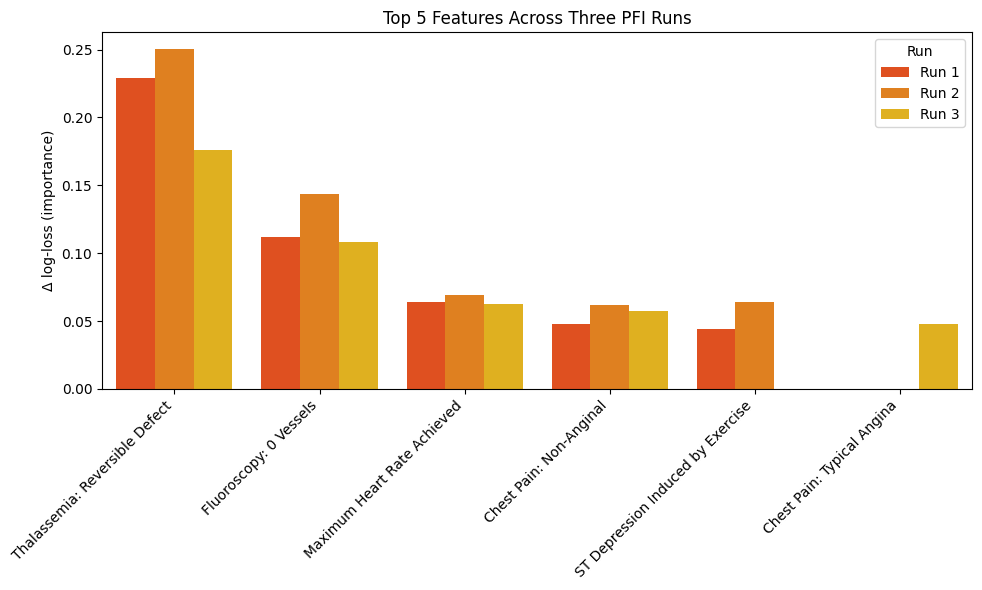

In [15]:
# Run PFI 3 times and store top 5 features from each run
pfi_runs = []

for run in range(1, 4):
    importances = []
    for name in feature_names:
        losses = []
        for _ in range(5):  # number of shuffles per feature
            X_perm = X_test_df.copy()
            X_perm[name] = np.random.permutation(X_perm[name].values)
            y_pred = model.predict(X_perm.values, verbose=0).flatten()
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
            losses.append(log_loss(y_test, y_pred))
        mean_loss = np.mean(losses)
        importances.append(mean_loss - baseline_loss)

    run_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Run': f'Run {run}'
    }).sort_values('Importance', ascending=False).head(5)  # Keep top 5
    pfi_runs.append(run_df)

# Combine results from all runs
pfi_all = pd.concat(pfi_runs, axis=0).reset_index(drop=True)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pfi_all,
    x="Feature",
    y="Importance",
    hue="Run",
    palette="autumn"
)

plt.title("Top 5 Features Across Three PFI Runs")
plt.ylabel("Δ log-loss (importance)")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Deeper‐Tree surrogate (max_depth=5) → R² = 0.858 | MSE = 0.02638


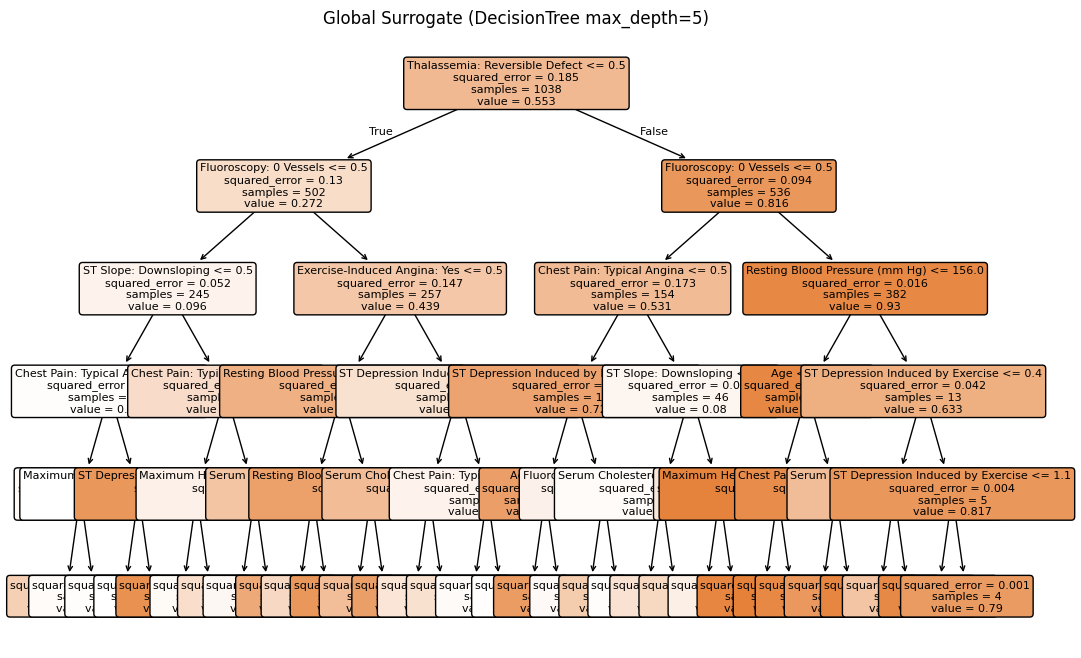

Logistic‐surrogate (threshold=0.5) → Accuracy = 0.873 | Log-Loss = 0.28629

Top 10 features by |coefficient|:
Thalassemia: Reversible Defect      1.1970
Fluoroscopy: 3 Vessels              1.0364
Fluoroscopy: 0 Vessels              0.9249
Thalassemia: Normal                 0.5295
ST Depression Induced by Exercise   0.4976
Fluoroscopy: 2 Vessels              0.4552
Chest Pain: Non-Anginal             0.4452
Maximum Heart Rate Achieved         0.4426
Chest Pain: Typical Angina          0.4091
Sex: Male                           0.3392


In [16]:

# ─────────────── PREPARE DATA ───────────────
feature_cols   = [c for c in df.columns if c != 'target']
df_train, df_holdout = train_test_split(
    df, test_size=0.2, stratify=df['target'], random_state=42
)

# Raw & scaled training inputs
raw_X_train    = df_train[feature_cols]
scaled_X_train = scaler.transform(raw_X_train.values)

# Black-box probabilities on train
y_bb_prob = model.predict(scaled_X_train, verbose=0).flatten()

# Binary labels (for logistic surrogate)
y_bb_class = (y_bb_prob > 0.5).astype(int)

# ──────────── 1) Deeper Tree (Regression) ────────────
tree5 = DecisionTreeRegressor(max_depth=5, random_state=42)
tree5.fit(raw_X_train, y_bb_prob)
y_tree5 = tree5.predict(raw_X_train)

r2_tree5    = r2_score(y_bb_prob, y_tree5)
mse_tree5   = mean_squared_error(y_bb_prob, y_tree5)
print(f"Deeper‐Tree surrogate (max_depth=5) → R² = {r2_tree5:.3f} | MSE = {mse_tree5:.5f}")

# (Optional) visualize the tree
plt.figure(figsize=(12,8))
plot_tree(tree5, feature_names=feature_cols, filled=True, rounded=True, fontsize=8)
plt.title("Global Surrogate (DecisionTree max_depth=5)")
plt.show()

# ──────────── 2) Logistic Regression (Classification) ────────────
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(scaled_X_train, y_bb_class)

# Surrogate predictions
y_log_pred  = logreg.predict(scaled_X_train)
y_log_proba = logreg.predict_proba(scaled_X_train)[:,1]

acc_log     = accuracy_score(y_bb_class, y_log_pred)
ll_log      = log_loss(y_bb_class, logreg.predict_proba(scaled_X_train))

print(f"Logistic‐surrogate (threshold=0.5) → Accuracy = {acc_log:.3f} | Log-Loss = {ll_log:.5f}")

# Show top 10 absolute coefficients
coef_ser = pd.Series(logreg.coef_[0], index=feature_cols).abs().sort_values(ascending=False)
print("\nTop 10 features by |coefficient|:")
print(coef_ser.head(10).to_string(float_format='%.4f'))


=== Surrogate Fidelity ===
Metric  Value
    R²  0.858
   MSE  0.026

=== Top 5 Features by Importance ===
                          Feature  Importance
   Thalassemia: Reversible Defect       0.465
           Fluoroscopy: 0 Vessels       0.196
       Chest Pain: Typical Angina       0.125
     Exercise-Induced Angina: Yes       0.056
ST Depression Induced by Exercise       0.051


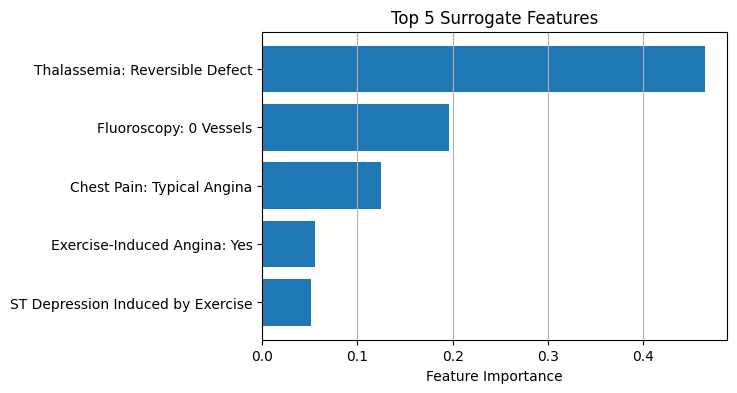


=== First 2 levels of the decision tree ===
|--- Thalassemia: Reversible Defect <= 0.50
|   |--- Fluoroscopy: 0 Vessels <= 0.50
|   |   |--- ST Slope: Downsloping <= 0.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- ST Slope: Downsloping >  0.50
|   |   |   |--- truncated branch of depth 3
|   |--- Fluoroscopy: 0 Vessels >  0.50
|   |   |--- Exercise-Induced Angina: Yes <= 0.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- Exercise-Induced Angina: Yes >  0.50
|   |   |   |--- truncated branch of depth 3
|--- Thalassemia: Reversible Defect >  0.50
|   |--- Fluoroscopy: 0 Vessels <= 0.50
|   |   |--- Chest Pain: Typical Angina <= 0.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- Chest Pain: Typical Angina >  0.50
|   |   |   |--- truncated branch of depth 3
|   |--- Fluoroscopy: 0 Vessels >  0.50
|   |   |--- Resting Blood Pressure (mm Hg) <= 156.00
|   |   |   |--- truncated branch of depth 3
|   |   |--- Resting Blood Pressure (mm Hg) >  156.00
| 

In [18]:
# 1) Get and sort feature importances
importances = pd.Series(tree5.feature_importances_, index=feature_cols)
top5_imp = importances.sort_values(ascending=False).head(5)

# 2) Build a table of top5 + fidelity metrics
metrics = {
    'Metric': ['R²', 'MSE'],
    'Value': [r2_tree5, mse_tree5]
}
metrics_df = pd.DataFrame(metrics)

top5_df = pd.DataFrame({
    'Feature': top5_imp.index,
    'Importance': top5_imp.values
})

# 3) Display tables
print("=== Surrogate Fidelity ===")
print(metrics_df.to_string(index=False, float_format="%.3f"))

print("\n=== Top 5 Features by Importance ===")
print(top5_df.to_string(index=False, float_format="%.3f"))

# 4) Bar chart of top-5
plt.figure(figsize=(6,4))
plt.barh(top5_df['Feature'][::-1], top5_df['Importance'][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 5 Surrogate Features")
plt.grid(axis='x')
plt.show()

# 5) Show the first two levels of the tree as text
tree_rules = export_text(tree5, feature_names=feature_cols, max_depth=2)
print("\n=== First 2 levels of the decision tree ===")
print(tree_rules)

Hold-out surrogate metrics:
  • R²   = 0.836
  • MSE  = 0.03054
  • MAE  = 0.107



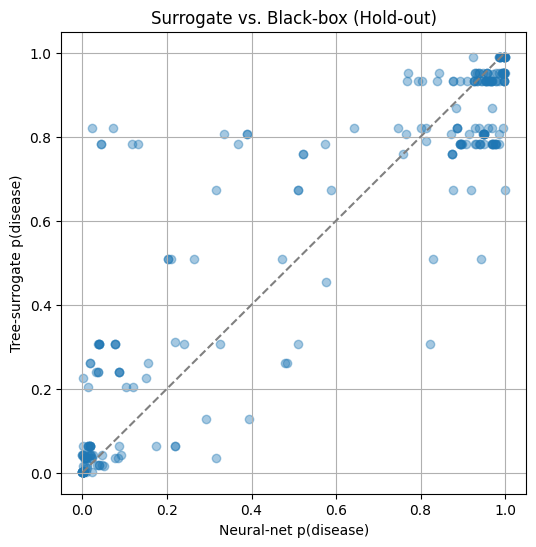

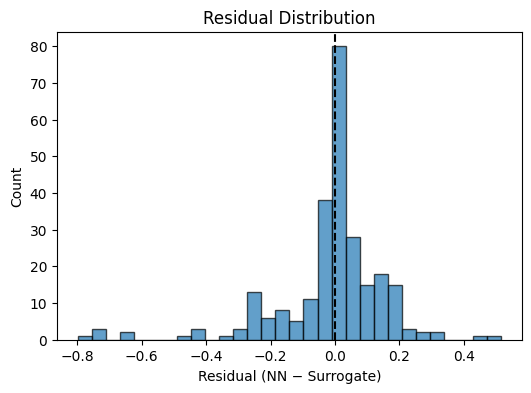

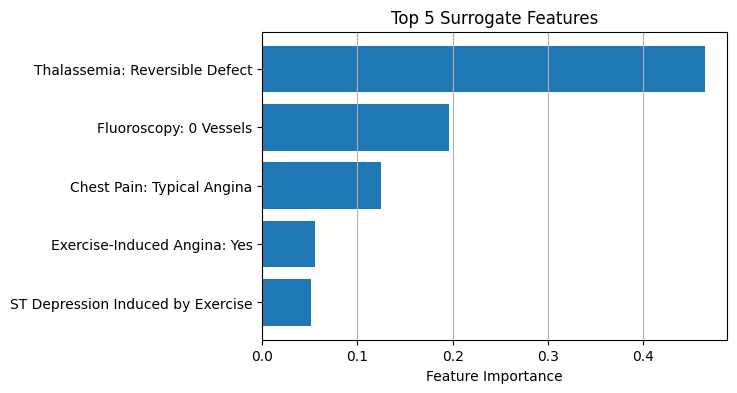

In [19]:
# ──────────── 1) Prepare hold-out data ────────────
feature_cols = [c for c in df.columns if c != 'target']
_, df_holdout = train_test_split(
    df, test_size=0.2, stratify=df['target'], random_state=0
)
raw_X_holdout    = df_holdout[feature_cols]
scaled_X_holdout = scaler.transform(raw_X_holdout.values)

# Black-box “true” probs on hold-out
y_bb_holdout = model.predict(scaled_X_holdout, verbose=0).flatten()

# Surrogate predictions on hold-out
y_tree_holdout = tree5.predict(raw_X_holdout)

# ──────────── 2) Compute metrics ────────────
r2  = r2_score(y_bb_holdout, y_tree_holdout)
mse = mean_squared_error(y_bb_holdout, y_tree_holdout)
mae = mean_absolute_error(y_bb_holdout, y_tree_holdout)

print(f"Hold-out surrogate metrics:")
print(f"  • R²   = {r2:.3f}")
print(f"  • MSE  = {mse:.5f}")
print(f"  • MAE  = {mae:.3f}\n")

# ──────────── 3) Scatter plot (predicted vs. true) ────────────
plt.figure(figsize=(6,6))
plt.scatter(y_bb_holdout, y_tree_holdout, alpha=0.4)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("Neural-net p(disease)")
plt.ylabel("Tree-surrogate p(disease)")
plt.title("Surrogate vs. Black-box (Hold-out)")
plt.grid(True)
plt.show()

# ──────────── 4) Residuals histogram ────────────
residuals = y_bb_holdout - y_tree_holdout
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Residual (NN − Surrogate)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()

# ──────────── 5) Feature-importance bar chart ────────────
importances = pd.Series(tree5.feature_importances_, index=feature_cols)
top5 = importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(6,4))
plt.barh(top5.index[::-1], top5.values[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 5 Surrogate Features")
plt.grid(axis='x')
plt.show()


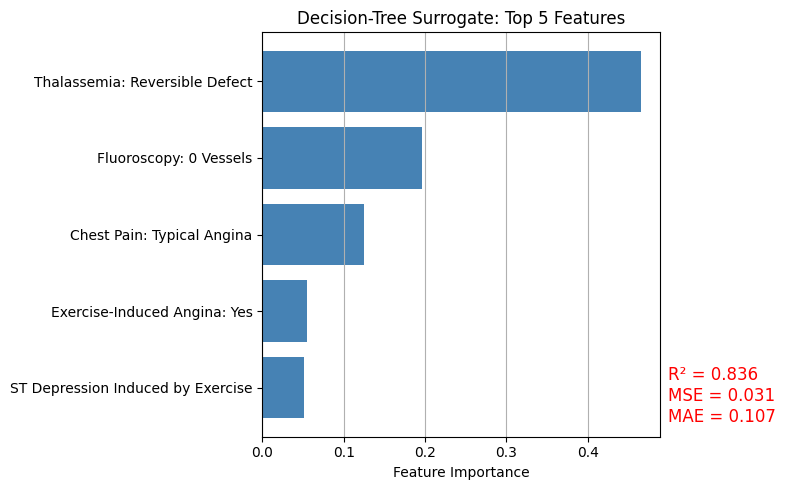

In [20]:
# ──────────── 5) Feature-importance bar chart (annotated with metrics) ────────────
importances = pd.Series(tree5.feature_importances_, index=feature_cols)
top5 = importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 5))
bars = plt.barh(top5.index[::-1], top5.values[::-1], color='steelblue')  # Plot in reverse for descending top-down

# Annotated regression metrics in red text on the right
metrics_text = f"R² = {r2:.3f}\nMSE = {mse:.3f}\nMAE = {mae:.3f}"
plt.text(
    1.02, 0.1, metrics_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    color='red',
    verticalalignment='center',
    horizontalalignment='left'
)

# Final plot styling
plt.xlabel("Feature Importance")
plt.title("Decision-Tree Surrogate: Top 5 Features")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
